In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [82]:
# Carregar dados
data = pd.read_csv("dataset.csv")

# Converter 'id' em datetime e definir como índice
data['timestamp'] = pd.to_datetime(data['id'], errors='coerce')
data.set_index('timestamp', inplace=True)

# Selecionar variáveis relevantes
variables = data[['ws100', 'humid', 'wdisp100', 'hour', 'wdir100']]

# Verificar valores ausentes
if variables.isnull().values.any():
    print("Dados contêm valores ausentes. Realizando interpolação.")
    variables = variables.interpolate()

# Separar a variável alvo ('ws100') das demais
ws100 = variables[['ws100']]
features = variables.drop('ws100', axis=1)

# Inicializar escaladores
scaler_features = MinMaxScaler()
scaler_ws100 = MinMaxScaler()

# Ajustar escaladores e transformar os dados
features_scaled = scaler_features.fit_transform(features)
ws100_scaled = scaler_ws100.fit_transform(ws100)

# Converter de volta para DataFrame para facilitar a manipulação
features_scaled = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
ws100_scaled = pd.DataFrame(ws100_scaled, columns=['ws100'], index=ws100.index)

# Combinar as features escaladas com a variável alvo escalada
variables_scaled = pd.concat([ws100_scaled, features_scaled], axis=1)


In [83]:
# Parâmetros para sequências de entrada e saída
sequence_length = 48   # Número de passos de tempo na sequência de entrada
step_ahead = 6         # Previsão para o sexto passo (1 hora de antecedência)
split_ratio = 0.80     # 80% para treinamento e 20% para teste

# Função para criar sequências de dados
def create_sequences(ws, features, seq_length, step_ahead):
    X = []
    y = []
    for i in range(len(ws) - seq_length - step_ahead + 1):
        X_seq = features.iloc[i:i+seq_length].values
        X.append(X_seq)
        y.append(ws.iloc[i + seq_length + step_ahead -1].values[0])
    return np.array(X), np.array(y)

# Divisão dos dados em treinamento e teste
split_index = int(len(variables_scaled) * split_ratio)
train_ws = ws100_scaled.iloc[:split_index]
train_features = features_scaled.iloc[:split_index]
test_ws = ws100_scaled.iloc[split_index:]
test_features = features_scaled.iloc[split_index:]

# Criar sequências para treinamento e teste
X_train, y_train = create_sequences(train_ws, train_features, sequence_length, step_ahead)
X_test, y_test = create_sequences(test_ws, test_features, sequence_length, step_ahead)

print(f"Forma de X_train: {X_train.shape}")  # (num_samples, sequence_length, num_features)
print(f"Forma de y_train: {y_train.shape}")  # (num_samples,)
print(f"Forma de X_test: {X_test.shape}")    # (num_samples, sequence_length, num_features)
print(f"Forma de y_test: {y_test.shape}")    # (num_samples,)


Forma de X_train: (5995, 48, 4)
Forma de y_train: (5995,)
Forma de X_test: (1460, 48, 4)
Forma de y_test: (1460,)


In [84]:
# Definir o modelo
# Definir o modelo aprimorado
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(sequence_length, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Compilar o modelo com um otimizador e uma função de perda customizada
def custom_loss(y_true, y_pred):
    # Atribuir maior peso para valores abaixo de 6 m/s
    weight = tf.where(y_true < 6, 2.0, 1.0)
    return tf.reduce_mean(weight * tf.square(y_true - y_pred))

model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss, metrics=['mae'])

# Callbacks para ajuste durante o treinamento
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Treinar o modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/100


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0857 - mae: 0.1463 - val_loss: 0.0266 - val_mae: 0.0893 - learning_rate: 0.0010
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0255 - mae: 0.0869 - val_loss: 0.0238 - val_mae: 0.0842 - learning_rate: 0.0010
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0233 - mae: 0.0835 - val_loss: 0.0214 - val_mae: 0.0789 - learning_rate: 0.0010
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0211 - mae: 0.0791 - val_loss: 0.0198 - val_mae: 0.0764 - learning_rate: 0.0010
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0193 - mae: 0.0752 - val_loss: 0.0327 - val_mae: 0.1030 - learning_rate: 0.0010
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0199 - mae: 0.0778 - val_loss: 0.0283 - val_mae: 0.0931 - learning_rate: 0.0010
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0177 - mae: 0.0730 - val_loss: 0.0256 - val_mae: 0.0888 - learning_rate: 0.0010
Epo

In [85]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Inversão da padronização para obter valores reais de ws100
y_pred_inv = scaler_ws100.inverse_transform(y_pred)
y_test_inv = scaler_ws100.inverse_transform(y_test.reshape(-1, 1))

# Calcular erro de previsão (residual)
residuals = np.abs(y_test_inv - y_pred_inv).flatten()

# Definir limiar para anomalias (por exemplo, 95% dos resíduos)
threshold = np.percentile(residuals, 95)
print(f"Limiar de erro para anomalias: {threshold}")

# Identificar anomalias
anomalies = residuals > threshold
print(f"Total de anomalias detectadas: {np.sum(anomalies)}")

# Converter para classes para relatório de classificação (Opcional)
# Aqui, consideramos anomalia como 1 e normal como 0
y_pred_class = anomalies.astype(int)
y_test_class = anomalies.astype(int)  # Neste contexto, ambos são baseados no limiar


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Limiar de erro para anomalias: 2.574438674926758
Total de anomalias detectadas: 73


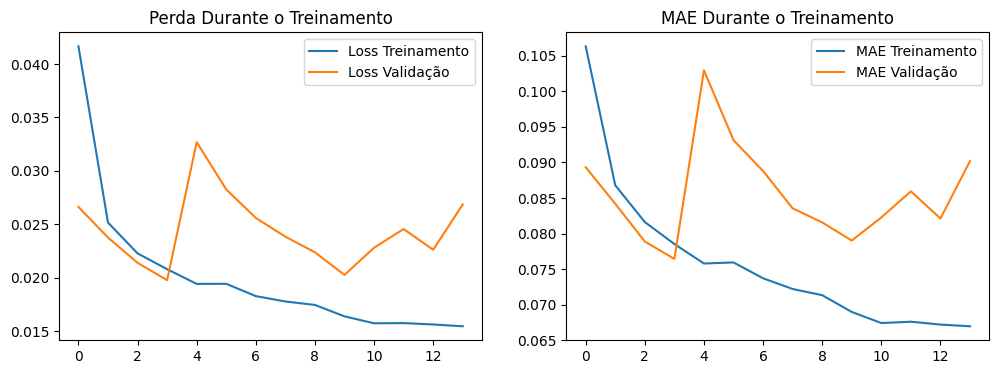

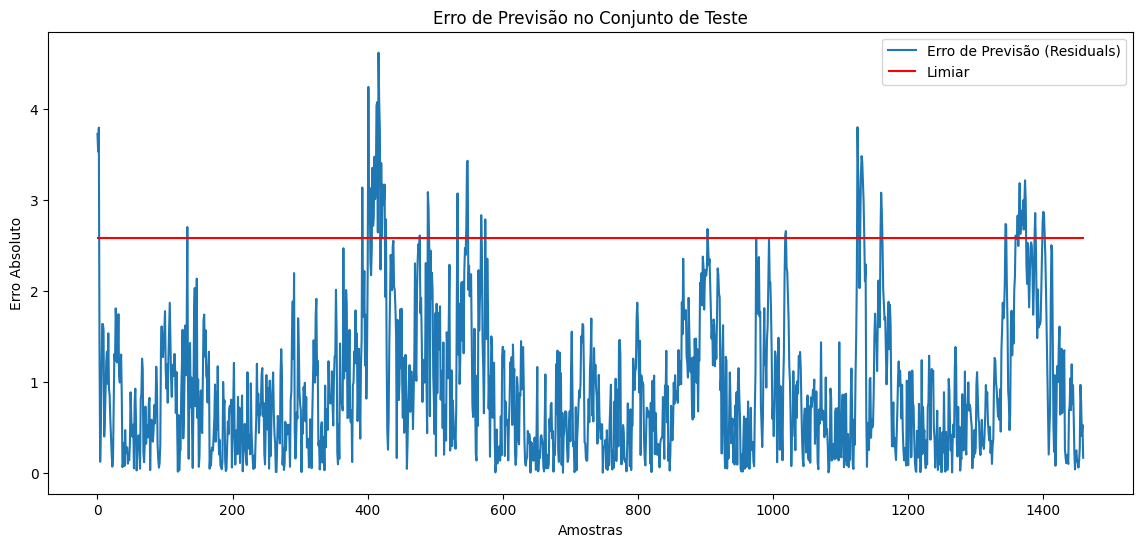

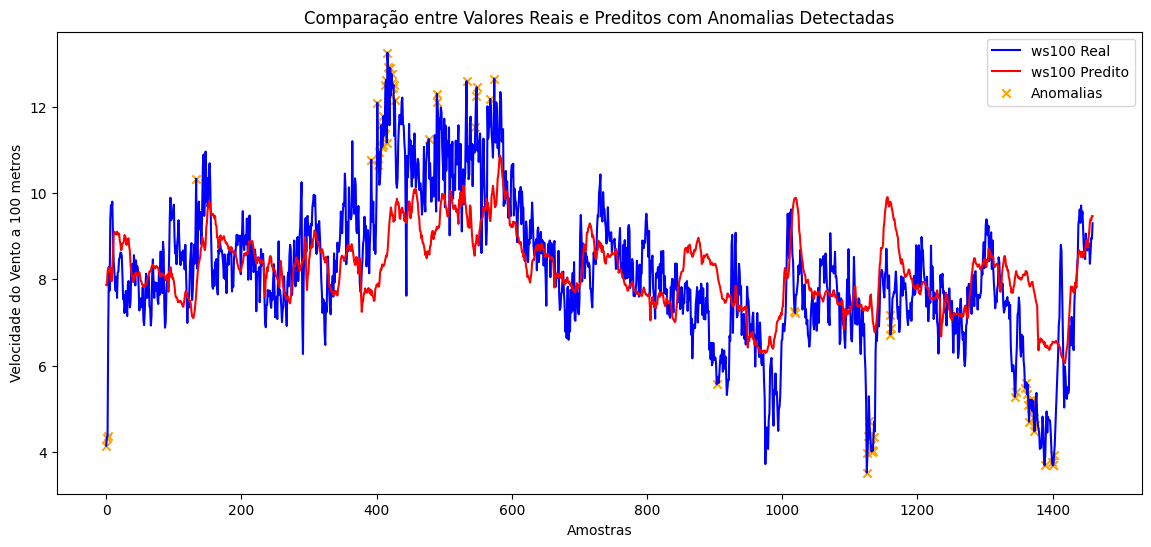

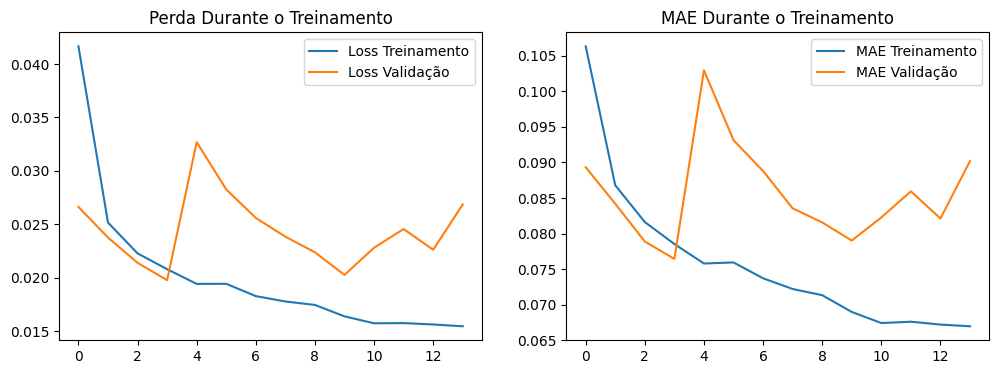

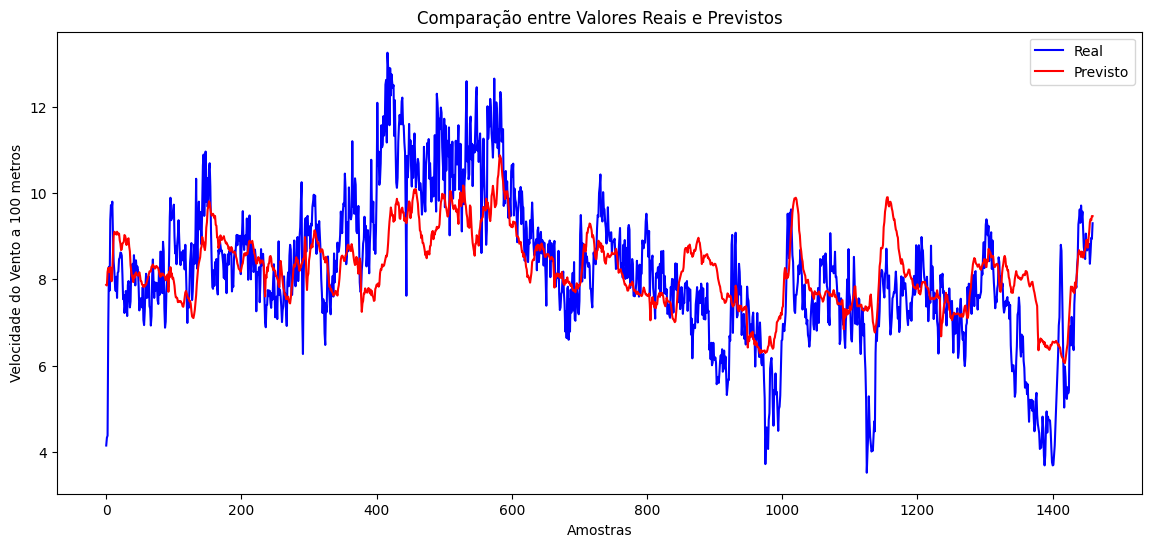

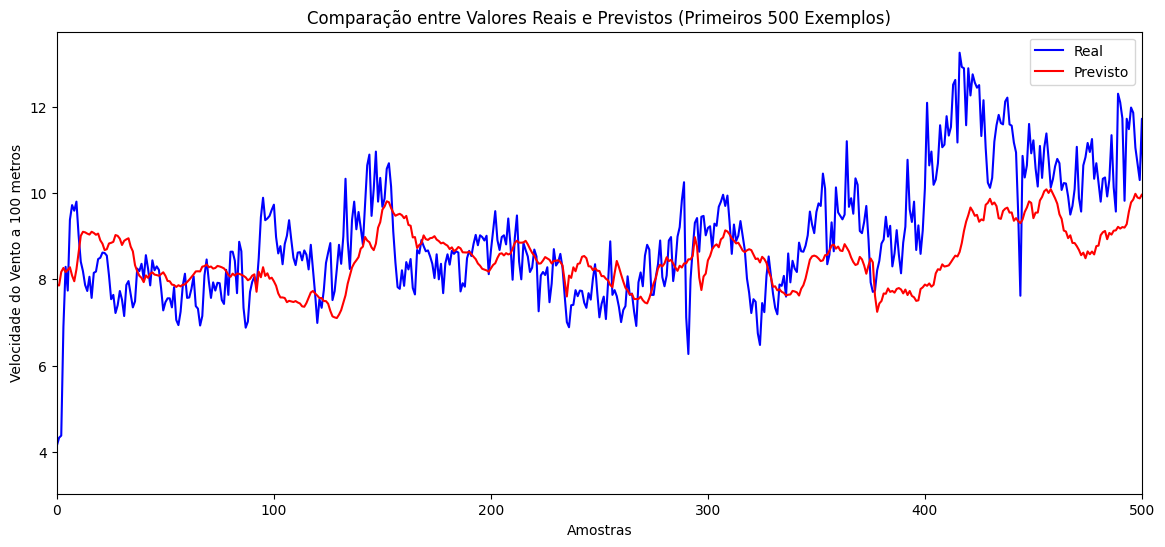

In [86]:
# Plotar o histórico de treinamento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss Treinamento')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.legend()
plt.title('Perda Durante o Treinamento')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE Treinamento')
plt.plot(history.history['val_mae'], label='MAE Validação')
plt.legend()
plt.title('MAE Durante o Treinamento')
plt.show()

# Plotar o erro de previsão
plt.figure(figsize=(14,6))
plt.plot(residuals, label='Erro de Previsão (Residuals)')
plt.hlines(threshold, xmin=0, xmax=len(residuals), colors='r', label='Limiar')
plt.legend()
plt.title('Erro de Previsão no Conjunto de Teste')
plt.xlabel('Amostras')
plt.ylabel('Erro Absoluto')
plt.show()

# Comparação entre Valores Reais e Preditos com Anomalias Destacadas
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='ws100 Real', color='blue')
plt.plot(y_pred_inv, label='ws100 Predito', color='red')
# Destacar as anomalias
plt.scatter(np.where(anomalies)[0], y_test_inv[anomalies], 
            color='orange', label='Anomalias', marker='x')
plt.legend()
plt.title('Comparação entre Valores Reais e Preditos com Anomalias Detectadas')
plt.xlabel('Amostras')
plt.ylabel('Velocidade do Vento a 100 metros')
plt.show()

# Plotar o histórico de treinamento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss Treinamento')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.legend()
plt.title('Perda Durante o Treinamento')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE Treinamento')
plt.plot(history.history['val_mae'], label='MAE Validação')
plt.legend()
plt.title('MAE Durante o Treinamento')
plt.show()

# Gráfico das Previsões Reais vs. Predições
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(y_pred_inv, label='Previsto', color='red')
plt.legend()
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Amostras')
plt.ylabel('Velocidade do Vento a 100 metros')
plt.show()

# Simulação da Previsão do Sexto Passo
# Como já estamos prevendo o sexto passo, o gráfico anterior já representa essa previsão.
# Contudo, para clareza, podemos destacar uma parte específica.

plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(y_pred_inv, label='Previsto', color='red')
plt.xlim(0, 500)  # Ajuste conforme necessário para visualizar melhor
plt.legend()
plt.title('Comparação entre Valores Reais e Previstos (Primeiros 500 Exemplos)')
plt.xlabel('Amostras')
plt.ylabel('Velocidade do Vento a 100 metros')
plt.show()
